In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
import os
import collections

pd.set_option("display.max_columns", None)

## 4-3 数値解析（予兆検知）

- 機器や社会インフラ設備などの稼働情報（センサーデータ）を分析して
- 「故障の予兆」を見つけるケース
- GMM: Gaussian Mixture Model（混合ガウス分布）

### 4-3-1 目的変数の例

### 4-3-2 分析方針の設計

### 4-3-3 データの加工

#### 定数の設定

In [2]:
# 入力ファイルが置かれたディレクトリ
INPUT_DIR_PATH = "../../support/src1300/src_ch04/4.3_予兆検知/"

# 正常データ
NORMAL_DATA_FILE_NAME = "正常データ.csv"
NORMAL_DATA_FILE_PATH = os.path.join(INPUT_DIR_PATH, NORMAL_DATA_FILE_NAME)

# 異常データ
ANOMALY_DATA_FILE_NAME = "異常データ.csv"
ANOMALY_DATA_FILE_PATH = os.path.join(INPUT_DIR_PATH, ANOMALY_DATA_FILE_NAME)

# 出力ファイル
OUTPUT_DIR_PATH = "./"
OUTPUT_ANOMALY_MEASURE_FILE_NAME = "anomaly_measure.csv"
OUTPUT_ANOMALY_MEASURE_FILE_PATH = os.path.join(OUTPUT_DIR_PATH, OUTPUT_ANOMALY_MEASURE_FILE_NAME)
OUTPUT_CLUSTER_FILE_NAME = "cluster_data_num.csv"
OUTPUT_CLUSTER_FILE_PATH = os.path.join(OUTPUT_DIR_PATH, OUTPUT_CLUSTER_FILE_NAME)

# 利用するカラム
USE_COLUMNS_LIST = ["sensor1", "sensor2", "sensor3"]

- 正常データ
  - 故障の影響が稼働データに出ていない時期のデータ
- 異常データ
  - 異常予兆として検知したい時期のデータ
- 過渡期データ
  - 正常データから異常データの間の期間
  - 今回は分析対象外

```bash
  <正常データ>      <過渡状態>         <異常データ>     <故障期間>
-------------|------------------|-----------------*------------|
     [故障発生 X 日前]   [故障発生 X2 日前]       [故障発生]      [復旧]
```

In [3]:
# 正常データ
normal_df = pd.read_csv(NORMAL_DATA_FILE_PATH, encoding="sjis", engine="python")
print("read normal data: " + str(normal_df.shape))

# 異常データ
anomaly_df = pd.read_csv(ANOMALY_DATA_FILE_PATH, encoding="sjis", engine="python")
print("read anomaly data: " + str(anomaly_df.shape))

read normal data: (960, 4)
read anomaly data: (192, 4)


In [4]:
display(normal_df)

,datetime,sensor1,sensor2,sensor3
0,2021-01-01 00:00:00,0.240000,1951.278035,468.306728
1,2021-01-01 00:15:00,0.264721,1569.336495,415.436891
2,2021-01-01 00:30:00,0.287023,1477.550263,424.090643
3,2021-01-01 00:45:00,0.304721,1279.563387,389.910295
4,2021-01-01 01:00:00,0.316085,963.057570,304.407591
...,...,...,...,...
955,2021-01-10 22:45:00,0.160000,4084.407868,653.505259
956,2021-01-10 23:00:00,0.163915,3833.272905,628.332763
957,2021-01-10 23:15:00,0.175279,3492.237699,612.114676
958,2021-01-10 23:30:00,0.192977,3099.656211,598.162914


In [5]:
display(anomaly_df)

,datetime,sensor1,sensor2,sensor3
0,2021-01-14 00:00:00,0.287023,1273.879258,383.052411
1,2021-01-14 00:15:00,0.264721,1473.365475,416.963050
2,2021-01-14 00:30:00,0.240000,1929.386561,498.388929
3,2021-01-14 00:45:00,0.215279,2307.645412,538.277802
4,2021-01-14 01:00:00,0.192977,2872.294000,599.400617
...,...,...,...,...
187,2021-01-15 22:45:00,0.160000,3357.433490,643.099257
188,2021-01-15 23:00:00,0.163915,3228.255924,635.007588
189,2021-01-15 23:15:00,0.175279,2924.308318,617.512932
190,2021-01-15 23:30:00,0.192977,2442.872622,572.829489


In [6]:
# 学習データ・検証データ
train_data = pd.concat([
    normal_df.loc[:, USE_COLUMNS_LIST],
    anomaly_df.loc[:, USE_COLUMNS_LIST],
])

test_normal_data = normal_df.loc[:, USE_COLUMNS_LIST]
test_anomaly_data = anomaly_df.loc[:, USE_COLUMNS_LIST]

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

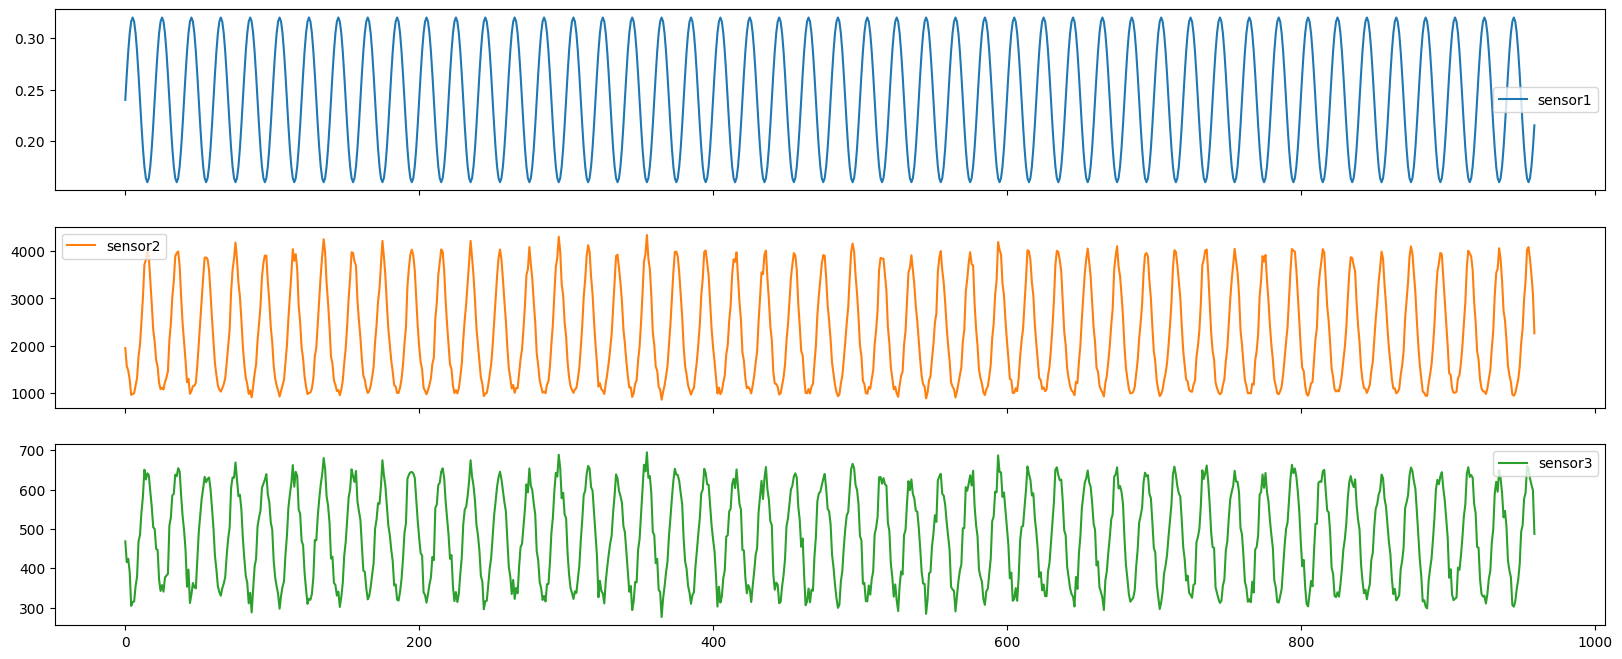

In [7]:
# 正常データ
test_normal_data.plot(subplots=True, figsize=(20, 8))

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object)

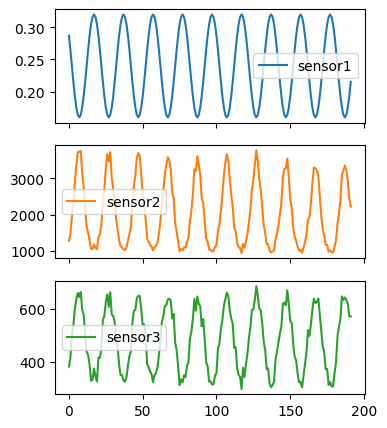

In [10]:
# 異常データの描画
test_anomaly_data.plot(subplots=True, figsize=(4, 5))

### 4-3-4 データ分析・モデリングおよび分析モデルの精度評価

#### 異常度の算出

In [20]:
# モデル構築（分布の推定）
n_component = 5
gmm = mixture.GaussianMixture(
    n_components=n_component,
    random_state=0
)
gmm.fit(test_normal_data)

GaussianMixture(n_components=5, random_state=0)

- 特徴度（異常度）
  - 各データの出現のめずらしさ
  - 値が大きいほど出現がめずらしく、特徴的なデータであることを表す

In [21]:
# 特徴度（異常度）の算出

# 正常データ
normal_data_anomaly_measures = -np.log(np.exp(gmm.score_samples(test_normal_data)))

# 異常データ
anomaly_data_anomaly_measures = -np.log(np.exp(gmm.score_samples(test_anomaly_data)))

<AxesSubplot: >

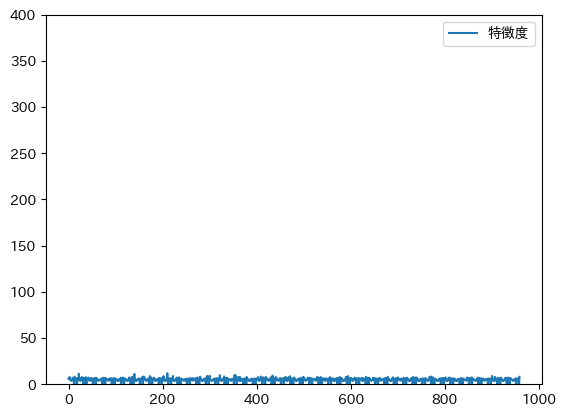

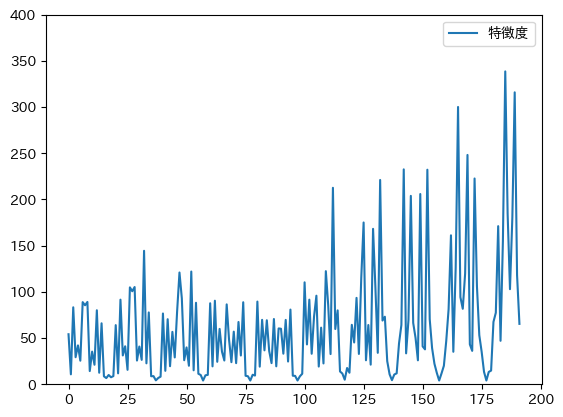

In [23]:
# 特徴度（異常度）の時系列グラフ
# x 軸が行数
# y 軸が特徴度（異常度）

plt.rcParams["font.family"] = "IPAexGothic"
pd.DataFrame(normal_data_anomaly_measures, columns=["特徴度"]).plot(ylim=[0, 400])
pd.DataFrame(anomaly_data_anomaly_measures, columns=["特徴度"]).plot(ylim=[0, 400])

#### クラスタごとのデータ数

In [24]:
# クラスタの取得
normal_data_cluster_list = gmm.predict(test_normal_data)
anomaly_data_cluster_list = gmm.predict(test_anomaly_data)

# 要素別にカウント
normal_cluster_count_dict = collections.Counter(normal_data_cluster_list)
anomaly_cluster_count_dict = collections.Counter(anomaly_data_cluster_list)

# データフレームを生成
cluster_list = range(0, n_component)
cluster_normal_data_num = []
cluster_anomaly_data_num = []

for cluster_idx in range(0, n_component):
    cluster_normal_data_num.append(normal_cluster_count_dict[cluster_idx])
    cluster_anomaly_data_num.append(anomaly_cluster_count_dict[cluster_idx])

cluster_data_num_df = pd.DataFrame([
    cluster_list, cluster_normal_data_num, cluster_anomaly_data_num
])
cluster_data_num_df = cluster_data_num_df.T
cluster_data_num_df.columns = ["cluster_index", "normal_data_num", "anomaly_data_num"]

display(cluster_data_num_df)

,cluster_index,normal_data_num,anomaly_data_num
0,0,240,41
1,1,96,0
2,2,192,74
3,3,240,34
4,4,192,43


#### クラスタごとのデータ数のヒストグラム

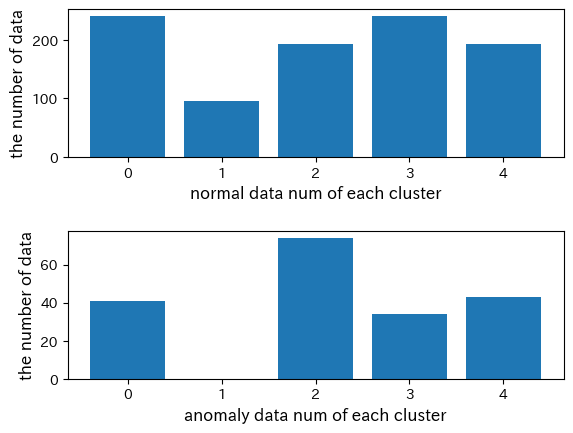

,cluster_index,normal_data_num,anomaly_data_num
0,0,240,41
1,1,96,0
2,2,192,74
3,3,240,34
4,4,192,43


In [25]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.2, hspace=0.5)

ax = fig.add_subplot(211)
plt.bar(
    cluster_data_num_df["cluster_index"],
    cluster_data_num_df["normal_data_num"],
    align="center"
)
ax.set_xlabel("normal data num of each cluster", fontsize=12)
ax.set_ylabel("the number of data", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax = fig.add_subplot(212)
plt.bar(
    cluster_data_num_df["cluster_index"],
    cluster_data_num_df["anomaly_data_num"],
    align="center"
)
ax.set_xlabel("anomaly data num of each cluster", fontsize=12)
ax.set_ylabel("the number of data", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()
display(cluster_data_num_df)

#### クラスタごとの中心座標

In [26]:
# クラスタごとの中心座標
cluster_means_pd = pd.DataFrame(gmm.means_)
cluster_means_pd.columns = USE_COLUMNS_LIST
display(cluster_means_pd)

,sensor1,sensor2,sensor3
0,0.312323,1077.640896,336.141740
1,0.192977,2971.039992,573.342919
2,0.227639,2228.273602,504.561943
3,0.167678,3738.978803,625.570015
4,0.275877,1482.436114,407.325732


#### クラスタごとのデータ数の出力

In [ ]:
cluster_data_num_df.to_csv(OUTPUT_CLUSTER_FILE_PATH, index=False, encoding="sjis")

#### クラスタごとの特徴度の描画

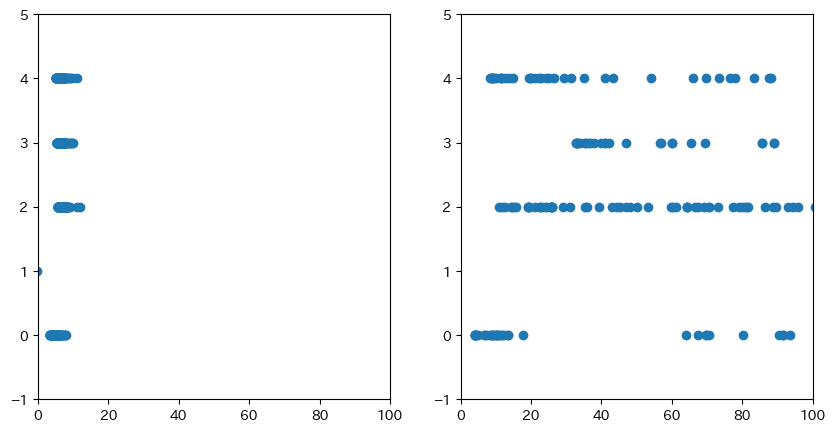

In [27]:
# クラスタごとの特徴度の分布
# x 軸が特徴度
# y 軸が書くクラスタの番号

normal_df["anomaly_measure"] = normal_data_anomaly_measures
normal_df["cluster_idx"] = normal_data_cluster_list

anomaly_df["anomaly_measure"] = anomaly_data_anomaly_measures
anomaly_df["cluster_idx"] = anomaly_data_cluster_list

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.scatter(normal_df["anomaly_measure"], normal_df["cluster_idx"])
ax.set_xlim(0, 100)
ax.set_ylim(-1, 5)

ax = fig.add_subplot(122)
ax.scatter(anomaly_df["anomaly_measure"], anomaly_df["cluster_idx"])
ax.set_xlim(0, 100)
ax.set_ylim(-1, 5)

plt.show()

ここからさらに

- 特徴度から予兆傾向がつかめるか
- ほかの期間の正常データをこのモデルに入力して誤報が発生しないか
- ほかの異常データをこのモデルに入力して失報が発生しないか

よいモデルができれば

- 特徴度をしきい値などで監視をすることにより機器・設備の故障予知を剣士することができる

予兆検知

- GMM
- マハラノビス・タグチ法
- カーネル主成分分析
- 状態空間モデル